In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np

# Set the device
device = 'cuda:0'

# Define the path to the dataset directory
data_dir = '/disk2/akm_files/akm_exp/RandomExp/Cats_Vs_Dogs_Dataset'

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Load the dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Calculate the lengths for train, val, and test splits (80-10-10 ratio)
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Define the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Define the Vision Transformer model for binary classification
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, embed_dim=768, image_size=256):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_patches = (image_size // patch_size) ** 2
        
        # Convolutional layer to extract patches
        self.conv = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )
        
        # CLS token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        # Positional embeddings
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # Extract patches
        x = self.conv(x)  # (batch_size, embed_dim, num_patches_y, num_patches_x)
        x = x.flatten(2)  # (batch_size, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (batch_size, num_patches, embed_dim)
        
        # Expand the CLS token to the batch size and concatenate
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (batch_size, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (batch_size, num_patches + 1, embed_dim)
        
        # Add positional embeddings
        x = x + self.pos_embedding
        
        return x

class VisionTransformer(nn.Module):
    def __init__(self, num_layers=12, num_heads=8, embed_dim=768, mlp_dim=2048):
        super(VisionTransformer, self).__init__()
        self.patch_embedding = PatchEmbedding(embed_dim=embed_dim)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=mlp_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Classification head for binary classification
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, 1),  # Output a single value for binary classification
            nn.Sigmoid()  # Apply sigmoid activation
        )
    
    def forward(self, x):
        x = self.patch_embedding(x)  # Patch embedding with CLS token and positional embeddings
        x = self.transformer_encoder(x)  # Transformer encoder
        cls_token_output = x[:, 0]  # CLS token output for classification
        logits = self.mlp_head(cls_token_output)  # Classification head
        return logits

In [5]:
# Instantiate the model
model = VisionTransformer().to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training settings
num_epochs = 10
early_stopping_patience = 5
best_val_loss = float('inf')
early_stopping_counter = 0

# Helper functions for accuracy
def calculate_accuracy(output, target):
    preds = (output > 0.5).float()
    correct = (preds == target).float().sum()
    return correct / len(target)

/disk2/akm_files/akm_exp/newipenv2/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [6]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0

    # Training step
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_acc += calculate_accuracy(outputs, labels).item()
            
            pbar.set_postfix(**{'loss': train_loss / len(train_loader), 'acc': train_acc / len(train_loader)})
            pbar.update(1)
    
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    
    # Validation step
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += calculate_accuracy(outputs, labels).item()
    
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1
    
    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping triggered")
        break

Epoch 1/10:  57%|█████▋    | 357/624 [01:58<01:22,  3.23batch/s, acc=0.286, loss=0.409]   /disk2/akm_files/akm_exp/newipenv2/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 1/10: 100%|██████████| 624/624 [03:26<00:00,  3.03batch/s, acc=0.502, loss=0.707]


Epoch 1/10, Train Loss: 0.7069, Train Acc: 0.5021, Val Loss: 0.6986, Val Acc: 0.5030


Epoch 2/10:  22%|██▏       | 137/624 [00:45<02:24,  3.36batch/s, acc=0.106, loss=0.153]   /disk2/akm_files/akm_exp/newipenv2/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 2/10: 100%|██████████| 624/624 [03:24<00:00,  3.05batch/s, acc=0.501, loss=0.696]


Epoch 2/10, Train Loss: 0.6963, Train Acc: 0.5007, Val Loss: 0.6943, Val Acc: 0.4970


Epoch 3/10:  24%|██▎       | 148/624 [00:48<02:23,  3.33batch/s, acc=0.118, loss=0.165]   /disk2/akm_files/akm_exp/newipenv2/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 3/10: 100%|██████████| 624/624 [03:26<00:00,  3.02batch/s, acc=0.499, loss=0.696]


Epoch 3/10, Train Loss: 0.6964, Train Acc: 0.4988, Val Loss: 0.6933, Val Acc: 0.4970


Epoch 4/10:  59%|█████▉    | 367/624 [02:01<01:23,  3.09batch/s, acc=0.294, loss=0.409]   /disk2/akm_files/akm_exp/newipenv2/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 4/10: 100%|██████████| 624/624 [03:26<00:00,  3.02batch/s, acc=0.499, loss=0.695]


Epoch 4/10, Train Loss: 0.6949, Train Acc: 0.4994, Val Loss: 0.7018, Val Acc: 0.4970


Epoch 5/10:  94%|█████████▎| 584/624 [03:12<00:14,  2.67batch/s, acc=0.469, loss=0.65]    /disk2/akm_files/akm_exp/newipenv2/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 5/10: 100%|██████████| 624/624 [03:25<00:00,  3.03batch/s, acc=0.5, loss=0.695]  


Epoch 5/10, Train Loss: 0.6950, Train Acc: 0.5003, Val Loss: 0.6958, Val Acc: 0.5030


Epoch 6/10:  55%|█████▍    | 342/624 [01:52<01:28,  3.18batch/s, acc=0.273, loss=0.381]   /disk2/akm_files/akm_exp/newipenv2/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 6/10: 100%|██████████| 624/624 [03:25<00:00,  3.04batch/s, acc=0.5, loss=0.695]  


Epoch 6/10, Train Loss: 0.6946, Train Acc: 0.5002, Val Loss: 0.7000, Val Acc: 0.4970


Epoch 7/10:   4%|▍         | 24/624 [00:07<03:01,  3.30batch/s, acc=0.0181, loss=0.027]  /disk2/akm_files/akm_exp/newipenv2/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 7/10: 100%|██████████| 624/624 [03:24<00:00,  3.05batch/s, acc=0.501, loss=0.695] 


Epoch 7/10, Train Loss: 0.6950, Train Acc: 0.5015, Val Loss: 0.7099, Val Acc: 0.4970


Epoch 8/10:  85%|████████▍ | 528/624 [02:53<00:34,  2.79batch/s, acc=0.428, loss=0.588]  /disk2/akm_files/akm_exp/newipenv2/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 8/10: 100%|██████████| 624/624 [03:25<00:00,  3.04batch/s, acc=0.502, loss=0.694]


Epoch 8/10, Train Loss: 0.6945, Train Acc: 0.5017, Val Loss: 0.6937, Val Acc: 0.5030
Early stopping triggered


In [7]:
# Load the best model for final evaluation
model.load_state_dict(torch.load('best_model.pth'))

# Final evaluation on the training set
model.eval()
final_train_loss = 0.0
final_train_acc = 0.0
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        final_train_loss += loss.item()
        final_train_acc += calculate_accuracy(outputs, labels).item()

final_train_loss /= len(train_loader)
final_train_acc /= len(train_loader)

# Final evaluation on the validation set
final_val_loss = 0.0
final_val_acc = 0.0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        final_val_loss += loss.item()
        final_val_acc += calculate_accuracy(outputs, labels).item()

final_val_loss /= len(val_loader)
final_val_acc /= len(val_loader)

print(f"Final Training Loss: {final_train_loss:.4f}, Final Training Acc: {final_train_acc:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}, Final Validation Acc: {final_val_acc:.4f}")

/disk2/akm_files/akm_exp/newipenv2/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:890: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Final Training Loss: 0.6933, Final Training Acc: 0.4978
Final Validation Loss: 0.6933, Final Validation Acc: 0.4970


In [8]:
# Final evaluation on the test set
final_test_loss = 0.0
final_test_acc = 0.0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        final_test_loss += loss.item()
        final_test_acc += calculate_accuracy(outputs, labels).item()

final_test_loss /= len(test_loader)
final_test_acc /= len(test_loader)

print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Acc: {final_test_acc:.4f}")

Final Test Loss: 0.6925, Final Test Acc: 0.5309


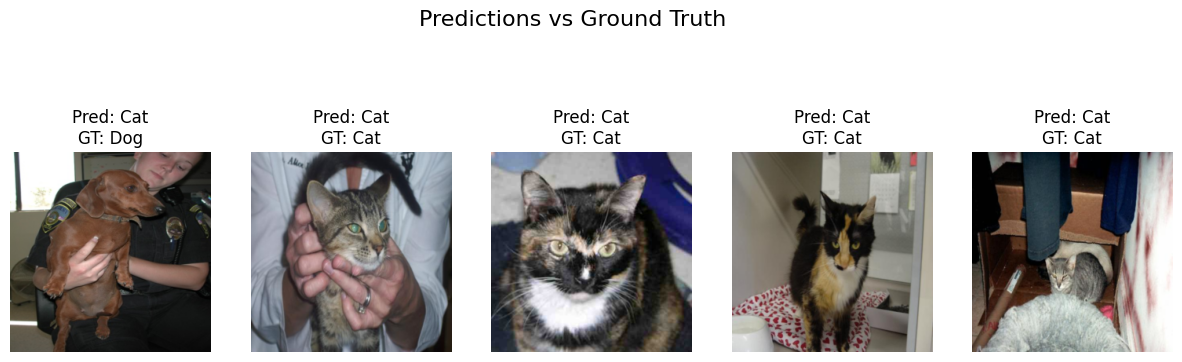

In [9]:
import matplotlib.pyplot as plt
import random

# Define class names
class_names = dataset.classes  # Assuming dataset.classes gives ['Cat', 'Dog']

# Function to visualize images with predicted and ground truth labels
def visualize_predictions(model, test_loader, device, num_samples=5):
    model.eval()  # Set the model to evaluation mode
    samples = random.sample(range(len(test_loader.dataset)), num_samples)
    
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))
    fig.suptitle('Predictions vs Ground Truth', fontsize=16)
    
    for i, sample_idx in enumerate(samples):
        image, label = test_loader.dataset[sample_idx]
        image = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(image)
            prediction = (output > 0.5).float().item()
        
        image = image.cpu().squeeze(0).permute(1, 2, 0).numpy()
        
        axs[i].imshow(image)
        axs[i].axis('off')
        pred_label = class_names[int(prediction)]
        true_label = class_names[label]
        axs[i].set_title(f'Pred: {pred_label}\nGT: {true_label}')
    
    plt.show()

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

# Visualize predictions
visualize_predictions(model, test_loader, device)